In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('news_dataset_last.csv',sep=';',index_col=0)

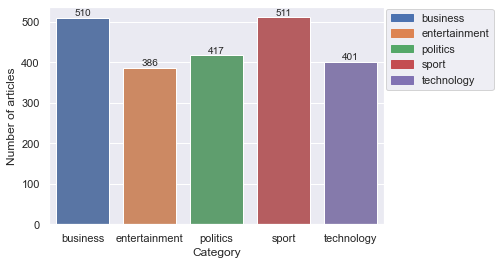

In [3]:
sns.set(rc={'figure.figsize':(6.5,4)})
ax=sns.barplot(x=df['Category'].unique(), y=df.groupby('Category').count()['Content'].values, 
               data=df)
ax.bar_label(ax.containers[0])
ax.set(ylabel='Number of articles')
ax.set(xlabel='Category')
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in ax.get_xticklabels())]
plt.legend(bbox_to_anchor=(1, 1),handles=patches, loc="upper left",borderaxespad=0.2)
plt.savefig('categories_count.png',bbox_inches = "tight")

In [4]:
df['News length'] = df['Content'].str.len()


In [5]:
#For better visualization in boxplots I removed text with lenght greater than 95% quantile
quantile_95 = df['News length'].quantile(0.95)
df_95 = df[df['News length'] < quantile_95]

In [6]:
df.groupby("Category").mean('News length')

,News length
Category,
business,1986.664706
entertainment,1928.339378
politics,2684.007194
sport,1896.485323
technology,2975.775561


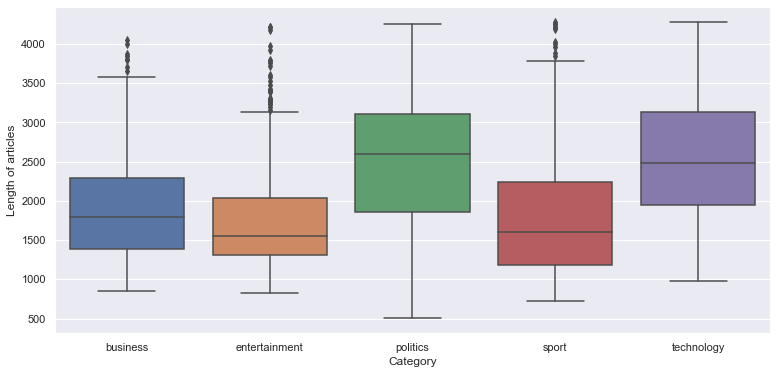

In [7]:
plt.figure(figsize=(12.8,6))
ax=sns.boxplot(data=df_95, x='Category', y='News length')
ax.set(ylabel='Length of articles')
plt.savefig('Text_length_boxplot.png')


# Feature Engineering

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

In [9]:
df['Content_clean_1'] = df['Content'].str.replace("\n", " ")
df['Content_clean_1'] = df['Content_clean_1'].str.replace("    ", " ")
df['Content_clean_1'] = df['Content_clean_1'].str.replace('"', '')
df['Content_clean_2'] = df['Content_clean_1'].str.lower()
punctuation_signs = list("?:!.,;")
df['Content_clean_3'] = df['Content_clean_2']

for punct_sign in punctuation_signs:
    df['Content_clean_3'] = df['Content_clean_3'].str.replace(punct_sign, '')


In [10]:
df['Content_clean_4'] = df['Content_clean_3'].str.replace("'s", "")

In [11]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdulla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:

df['Content_clean_5'] = df['Content_clean_4']
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_clean_5'] = df['Content_clean_5'].str.replace(regex_stopword, '')

In [13]:
df['Length_after_stopwords'] = df['Content_clean_5'].str.len()


In [14]:
df.groupby("Category").mean('length_After_stopwords')

,News length,Length_after_stopwords
Category,,
business,1986.664706,1577.362745
entertainment,1928.339378,1500.007772
politics,2684.007194,2058.592326
sport,1896.485323,1436.418787
technology,2975.775561,2297.244389


In [15]:
final_columns = ["File_Name", "Category", "Complete_Filename", "Content", "Content_clean_5"]
df = df[final_columns]

In [16]:
categories = {
    'sport': 0,
    'entertainment': 1,
    'technology': 2,
    'business': 3,
    'politics': 4
}
temp={'Category':categories.keys(),'Code':categories.values()}
pd.DataFrame(temp)

,Category,Code
0,sport,0
1,entertainment,1
2,technology,2
3,business,3
4,politics,4


In [17]:
df['CategoryID'] = df['Category']
df = df.replace({'CategoryID':categories})

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_clean_5'], 
                                                    df['CategoryID'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [19]:
ngram_range = [(1,2),(1,3)]
min_df = [10,6]
max_df = [1.,0.95]
max_features = [300,350]

In [20]:
train_features=[1,2]
train_labels=[1,2]
test_features=[1,2]
test_labels=[1,2]

for i in range(2):
    tfidf = TfidfVectorizer(encoding='utf-8',
                            ngram_range=ngram_range[i],
                            stop_words=None,
                            lowercase=False,
                            max_df=max_df[i],
                            min_df=min_df[i],
                            max_features=max_features[i],
                            norm='l2',
                            sublinear_tf=True)

    train_features[i]= tfidf.fit_transform(X_train).toarray()
    train_labels[i]=y_train
    print(train_features[i].shape)
    test_features[i]= tfidf.transform(X_test).toarray()
    test_labels[i]=y_test
    print(test_features[i].shape)

(1891, 300)
(334, 300)
(1891, 350)
(334, 350)


In [21]:
for i in range(2):
    for Product, category_id in sorted(categories.items()):
        features_chi2 = chi2(train_features[i], train_labels[i]== category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams=[v for v in feature_names if len(v.split(' ')) == 3]
        print("# '{}' category:".format(Product))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
        #print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-1:])))
        print("")

# 'business' category:
  . Most correlated unigrams:
. need
. day
. announced
. four
. media
  . Most correlated bigrams:
. prime minister
. mr brown

# 'entertainment' category:
  . Most correlated unigrams:
. economy
. real
. always
. american
. economic
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. scotland
. bbc
. days
. mobile
. held
  . Most correlated bigrams:
. mr brown
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. south
. film
. play
. latest
. club
  . Most correlated bigrams:
. mr brown
. prime minister

# 'technology' category:
  . Most correlated unigrams:
. cup
. rise
. case
. quarter
. services
  . Most correlated bigrams:
. prime minister
. last year

# 'business' category:
  . Most correlated unigrams:
. economy
. bank
. growth
. oil
. shares
  . Most correlated bigrams:
. last year
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. films
. star
. award
. awards
. 

In [22]:
with open('dataframe.pkl',mode='wb')as file:
    pickle.dump(df,file)
with open('train_features1.pkl',mode='wb')as file:
    pickle.dump(train_features[0],file)
with open('train_features2.pkl',mode='wb')as file:
    pickle.dump(train_features[1],file)
with open('train_labels.pkl',mode='wb')as file:
    pickle.dump(train_labels[0],file)
with open('test_features1.pkl',mode='wb')as file:
    pickle.dump(test_features[0],file)
with open('test_features2.pkl',mode='wb')as file:
    pickle.dump(test_features[1],file)
with open('test_labels.pkl',mode='wb')as file:
    pickle.dump(test_labels[0],file)
    

In [23]:
df.shape

(2225, 6)